In [1]:
# imported data are from Kaggle : https://www.kaggle.com/drgilermo/nba-players-stats/data#Seasons_Stats.csv
import pandas as pd 
data = pd.read_csv("C:/Users/Adam/Desktop/data/nba/Seasons_Stats.csv")
data.head()

Unnamed: 0    Year           Player  Pos   Age   Tm     G  GS  MP  PER  \
0           0  1950.0  Curly Armstrong  G-F  31.0  FTW  63.0 NaN NaN  NaN   
1           1  1950.0     Cliff Barker   SG  29.0  INO  49.0 NaN NaN  NaN   
2           2  1950.0    Leo Barnhorst   SF  25.0  CHS  67.0 NaN NaN  NaN   
3           3  1950.0       Ed Bartels    F  24.0  TOT  15.0 NaN NaN  NaN   
4           4  1950.0       Ed Bartels    F  24.0  DNN  13.0 NaN NaN  NaN   

   ...    FT%  ORB  DRB  TRB    AST  STL  BLK  TOV     PF    PTS  
0  ...  0.705  NaN  NaN  NaN  176.0  NaN  NaN  NaN  217.0  458.0  
1  ...  0.708  NaN  NaN  NaN  109.0  NaN  NaN  NaN   99.0  279.0  
2  ...  0.698  NaN  NaN  NaN  140.0  NaN  NaN  NaN  192.0  438.0  
3  ...  0.559  NaN  NaN  NaN   20.0  NaN  NaN  NaN   29.0   63.0  
4  ...  0.548  NaN  NaN  NaN   20.0  NaN  NaN  NaN   27.0   59.0  

[5 rows x 53 columns]

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as func

spark = SparkSession.builder.appName("first").getOrCreate()
nba = spark.read.csv("C:/Users/Adam/Desktop/data/nba/Seasons_Stats.csv", header=True, inferSchema=True)
nba.show(5)

+---+----+---------------+---+---+---+---+----+----+----+-----+----+-----+----+----+----+----+----+----+----+----+-----+----+----+----+-----+------+----+----+----+----+---+---+-----+----+----+----+---+---+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+---+
|_c0|Year|         Player|Pos|Age| Tm|  G|  GS|  MP| PER|  TS%|3PAr|  FTr|ORB%|DRB%|TRB%|AST%|STL%|BLK%|TOV%|USG%|blanl| OWS| DWS|  WS|WS/48|blank2|OBPM|DBPM| BPM|VORP| FG|FGA|  FG%|  3P| 3PA| 3P%| 2P|2PA|  2P%| eFG%| FT|FTA|  FT%| ORB| DRB| TRB|AST| STL| BLK| TOV| PF|PTS|
+---+----+---------------+---+---+---+---+----+----+----+-----+----+-----+----+----+----+----+----+----+----+----+-----+----+----+----+-----+------+----+----+----+----+---+---+-----+----+----+----+---+---+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+---+
|  0|1950|Curly Armstrong|G-F| 31|FTW| 63|null|null|null|0.368|null|0.467|null|null|null|null|null|null|null|null| null|-0.1| 3.6| 3.5| null|  null|null|null|null|null|144|516|0.

In [3]:
nba.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Player: string (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tm: string (nullable = true)
 |-- G: integer (nullable = true)
 |-- GS: integer (nullable = true)
 |-- MP: integer (nullable = true)
 |-- PER: double (nullable = true)
 |-- TS%: double (nullable = true)
 |-- 3PAr: double (nullable = true)
 |-- FTr: double (nullable = true)
 |-- ORB%: double (nullable = true)
 |-- DRB%: double (nullable = true)
 |-- TRB%: double (nullable = true)
 |-- AST%: double (nullable = true)
 |-- STL%: double (nullable = true)
 |-- BLK%: double (nullable = true)
 |-- TOV%: double (nullable = true)
 |-- USG%: double (nullable = true)
 |-- blanl: string (nullable = true)
 |-- OWS: double (nullable = true)
 |-- DWS: double (nullable = true)
 |-- WS: double (nullable = true)
 |-- WS/48: double (nullable = true)
 |-- blank2: string (nullable = true)
 |-- OBPM: double (nullable = 

In [4]:
print(len(nba.columns),nba.count())

53 24691


In [5]:
# we are interested in data from 1980 year
new = nba.filter(nba.Year > 1979)
print(len(new.columns),new.count())

53 18927


In [6]:
# drop unimportant columns
newnba = new.select(['_c0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PA','3PAr','PTS'])

In [7]:
def find_missing_values_columns(df):
    nrow = df.count()
    for v in df.columns:
        summary_df = df.select(v).describe()
        v_count = int(summary_df.collect()[0][v])
        if v_count < nrow:
            missing_percentage = (1 - v_count/nrow) * 100
            print("Total observations: " + str(nrow) + "\n"
            "Total observations of " + v + ": " + str(v_count) + "\n"
            "Percentage of missing values: " + str(missing_percentage) + "%" + "\n" "----------------------------")


In [8]:
find_missing_values_columns(newnba)

Total observations: 18927
Total observations of PER: 18922
Percentage of missing values: 0.026417287472924045%
----------------------------
Total observations: 18927
Total observations of TS%: 18851
Percentage of missing values: 0.4015427695884144%
----------------------------
Total observations: 18927
Total observations of 3PAr: 18839
Percentage of missing values: 0.46494425952343654%
----------------------------


In [9]:
#Task 1
group_data = newnba.groupBy("Player")
df = group_data.agg({'PTS':'sum'})
df.orderBy(df["sum(PTS)"].desc()).show()

+------------------+--------+
|            Player|sum(PTS)|
+------------------+--------+
|      Karl Malone*|   36928|
|       Kobe Bryant|   33643|
|   Michael Jordan*|   32292|
|     Dirk Nowitzki|   30260|
|     Eddie Johnson|   29779|
| Shaquille O'Neal*|   29428|
|      LeBron James|   28787|
|Dominique Wilkins*|   28591|
|      Vince Carter|   27463|
|    Allen Iverson*|   27457|
|  Hakeem Olajuwon*|   26946|
|        Tim Duncan|   26496|
|       Paul Pierce|   26397|
|     Kevin Garnett|   26394|
|         Ray Allen|   26218|
|   Carmelo Anthony|   26126|
|    Reggie Miller*|   25279|
|    Patrick Ewing*|   24815|
|     Alex English*|   24532|
|    Clyde Drexler*|   23848|
+------------------+--------+
only showing top 20 rows



In [10]:
#Task 2
add_column = newnba.withColumnRenamed("3PAr", "PA")
add_column = add_column.withColumn("PA_per_game",add_column.PA*add_column.MP )

In [11]:
# summed points and matches
group_data2 = add_column.groupBy("Year")
df2 = group_data2.agg({'PA_per_game':'sum','MP':'sum'}).withColumnRenamed("sum(PA_per_game)", "summed_PA"
                                                                        ).withColumnRenamed("sum(MP)", "summed_MP")
df2 = df2.orderBy(df2["Year"])
df2.show()

+----+---------+------------------+
|Year|summed_MP|         summed_PA|
+----+---------+------------------+
|1980|   484812|14213.578000000001|
|1981|   484370|11268.115999999998|
|1982|   490771|12333.990999999995|
|1983|   498741|11899.992999999993|
|1984|   465432|12246.506000000008|
|1985|   466340|15544.340999999997|
|1986|   476128| 18046.41099999999|
|1987|   476767|         24232.278|
|1988|   507434|29311.195999999996|
|1989|   535650| 38600.39599999999|
|1990|   571889|41973.037000000004|
|1991|   565462|43266.924000000006|
|1992|   556538|          45758.42|
|1993|   553795| 55985.48999999996|
|1994|   568690| 62660.37799999995|
|1995|   560989|101653.33800000005|
|1996|   637689|121965.26199999999|
|1997|   632501|131275.61199999996|
|1998|   636844|100994.02499999995|
|1999|   370984| 62125.68600000005|
+----+---------+------------------+
only showing top 20 rows



In [12]:

add_column = df2.withColumn("PA_per_game",df2.summed_PA/(df2.summed_MP/48)*2)
add_column.show()

+----+---------+------------------+------------------+
|Year|summed_MP|         summed_PA|       PA_per_game|
+----+---------+------------------+------------------+
|1980|   484812|14213.578000000001| 2.814500235142695|
|1981|   484370|11268.115999999998|2.2332909470033235|
|1982|   490771|12333.990999999995| 2.412659134300925|
|1983|   498741|11899.992999999993|2.2905663019483047|
|1984|   465432|12246.506000000008| 2.525964213891612|
|1985|   466340|15544.340999999997| 3.199932958785435|
|1986|   476128| 18046.41099999999|3.6386338463606402|
|1987|   476767|         24232.278| 4.879319852254874|
|1988|   507434|29311.195999999996| 5.545302080664677|
|1989|   535650| 38600.39599999999| 6.918021125735087|
|1990|   571889|41973.037000000004|7.0457930682352705|
|1991|   565462|43266.924000000006| 7.345541705720279|
|1992|   556538|          45758.42| 7.893096823577186|
|1993|   553795| 55985.48999999996| 9.705047969013798|
|1994|   568690| 62660.37799999995| 10.57763682850058|
|1995|   5

In [13]:
df_pandas = add_column.toPandas()
df_pandas


Year  summed_MP   summed_PA  PA_per_game
0   1980     484812   14213.578     2.814500
1   1981     484370   11268.116     2.233291
2   1982     490771   12333.991     2.412659
3   1983     498741   11899.993     2.290566
4   1984     465432   12246.506     2.525964
5   1985     466340   15544.341     3.199933
6   1986     476128   18046.411     3.638634
7   1987     476767   24232.278     4.879320
8   1988     507434   29311.196     5.545302
9   1989     535650   38600.396     6.918021
10  1990     571889   41973.037     7.045793
11  1991     565462   43266.924     7.345542
12  1992     556538   45758.420     7.893097
13  1993     553795   55985.490     9.705048
14  1994     568690   62660.378    10.577637
15  1995     560989  101653.338    17.395565
16  1996     637689  121965.262    18.361090
17  1997     632501  131275.612    19.924804
18  1998     636844  100994.025    15.224178
19  1999     370984   62125.686    16.076343
20  2000     595454   98275.262    15.844087
21  2001     623500  102805.231    15.828873
22  2002     610770  106949.158    16.810124
23  2003     608151  106857.966    16.868121
24  2004     653247  115703.844    17.003628
25  2005     661641  128629.242    18.663304
26  2006     646039  126734.182    18.832426
27  2007     630031  129658.231    19.756473
28  2008     654568  140154.946    20.555351
29  2009     662148  149459.176    21.668994
30  2010     656676  145828.539    21.318793
31  2011     686746  157013.166    21.948819
32  2012     507163  113010.894    21.391635
33  2013     637705  156365.204    23.539191
34  2014     651866  170840.164    25.159551
35  2015     678196  184227.363    26.077752
36  2016     638580  182926.885    27.500048
37  2017     648955  207840.309    30.745845

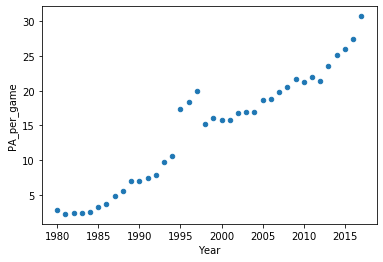

In [14]:
df_pandas.plot(x ='Year', y='PA_per_game', kind = 'scatter')

In [15]:
#Task3
df_filled = add_column.select(['Year','PA_per_game']).withColumnRenamed('PA_per_game', "label")
df_filled.show()

+----+------------------+
|Year|             label|
+----+------------------+
|1980| 2.814500235142695|
|1981|2.2332909470033235|
|1982| 2.412659134300925|
|1983|2.2905663019483047|
|1984| 2.525964213891612|
|1985| 3.199932958785435|
|1986|3.6386338463606402|
|1987| 4.879319852254874|
|1988| 5.545302080664677|
|1989| 6.918021125735087|
|1990|7.0457930682352705|
|1991| 7.345541705720279|
|1992| 7.893096823577186|
|1993| 9.705047969013798|
|1994| 10.57763682850058|
|1995|17.395564704477277|
|1996|18.361090048597354|
|1997|19.924804469874353|
|1998|15.224177977652289|
|1999|16.076342526901445|
+----+------------------+
only showing top 20 rows



In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
all_stages = [VectorAssembler(inputCols=['Year'], outputCol = 'features')]
df_new = Pipeline(stages=all_stages).fit(df_filled).transform(df_filled)
df_new.show()

+----+------------------+--------+
|Year|             label|features|
+----+------------------+--------+
|1980| 2.814500235142695|[1980.0]|
|1981|2.2332909470033235|[1981.0]|
|1982| 2.412659134300925|[1982.0]|
|1983|2.2905663019483047|[1983.0]|
|1984| 2.525964213891612|[1984.0]|
|1985| 3.199932958785435|[1985.0]|
|1986|3.6386338463606402|[1986.0]|
|1987| 4.879319852254874|[1987.0]|
|1988| 5.545302080664677|[1988.0]|
|1989| 6.918021125735087|[1989.0]|
|1990|7.0457930682352705|[1990.0]|
|1991| 7.345541705720279|[1991.0]|
|1992| 7.893096823577186|[1992.0]|
|1993| 9.705047969013798|[1993.0]|
|1994| 10.57763682850058|[1994.0]|
|1995|17.395564704477277|[1995.0]|
|1996|18.361090048597354|[1996.0]|
|1997|19.924804469874353|[1997.0]|
|1998|15.224177977652289|[1998.0]|
|1999|16.076342526901445|[1999.0]|
+----+------------------+--------+
only showing top 20 rows



In [17]:
to_predict = spark.createDataFrame([
(2018, 30),
(2019, 30),
(2020, 30),
(2021, 30),
(2022, 30)],
['Year', 'label']
)


In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
all_stages = [VectorAssembler(inputCols=['Year'], outputCol = 'features')]
test = Pipeline(stages=all_stages).fit(to_predict).transform(to_predict)
test.show()

+----+-----+--------+
|Year|label|features|
+----+-----+--------+
|2018|   30|[2018.0]|
|2019|   30|[2019.0]|
|2020|   30|[2020.0]|
|2021|   30|[2021.0]|
|2022|   30|[2022.0]|
+----+-----+--------+



In [20]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [21]:
lr_model = lr.fit(df_new)

In [22]:
pred1 = lr_model.transform(df_new)
pred1.show()

+----+------------------+--------+------------------+
|Year|             label|features|        prediction|
+----+------------------+--------+------------------+
|1980| 2.814500235142695|[1980.0]|1.0380671114214692|
|1981|2.2332909470033235|[1981.0]|1.7579444232817423|
|1982| 2.412659134300925|[1982.0]|2.4778217351422427|
|1983|2.2905663019483047|[1983.0]| 3.197699047002743|
|1984| 2.525964213891612|[1984.0]| 3.917576358863016|
|1985| 3.199932958785435|[1985.0]| 4.637453670723289|
|1986|3.6386338463606402|[1986.0]|  5.35733098258379|
|1987| 4.879319852254874|[1987.0]|  6.07720829444429|
|1988| 5.545302080664677|[1988.0]| 6.797085606304563|
|1989| 6.918021125735087|[1989.0]| 7.516962918164836|
|1990|7.0457930682352705|[1990.0]| 8.236840230025336|
|1991| 7.345541705720279|[1991.0]| 8.956717541885837|
|1992| 7.893096823577186|[1992.0]|  9.67659485374611|
|1993| 9.705047969013798|[1993.0]|10.396472165606383|
|1994| 10.57763682850058|[1994.0]|11.116349477466883|
|1995|17.395564704477277|[19

In [23]:
pred2 = lr_model.transform(test)
pred2.show()

+----+-----+--------+------------------+
|Year|label|features|        prediction|
+----+-----+--------+------------------+
|2018|   30|[2018.0]|28.393404962116165|
|2019|   30|[2019.0]|29.113282273976665|
|2020|   30|[2020.0]| 29.83315958583694|
|2021|   30|[2021.0]| 30.55303689769721|
|2022|   30|[2022.0]| 31.27291420955771|
+----+-----+--------+------------------+



In [24]:
print("Coefficient: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficient: [0.7198773118603867]
Intercept: -1424.3190103721442


In [25]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 2.061716
r2: 0.936144


In [26]:
df_new.describe().show()

+-------+------------------+------------------+
|summary|              Year|             label|
+-------+------------------+------------------+
|  count|                38|                38|
|   mean|            1998.5|14.355797380838746|
| stddev|11.113055385446435| 8.268381847942853|
|    min|              1980|2.2332909470033235|
|    max|              2017|  30.7458447257514|
+-------+------------------+------------------+



In [27]:
# R squared at 0.936144 indicates that in our model, approximate 94% of the variability in 'label' 
# can be explained using the model
# RMSE compared with label values, such as mean, min and max looks pretty good.

In [28]:
pandas_pred = pred1.union(pred2).toPandas()
pandas_pred

Year      label  features  prediction
0   1980   2.814500  [1980.0]    1.038067
1   1981   2.233291  [1981.0]    1.757944
2   1982   2.412659  [1982.0]    2.477822
3   1983   2.290566  [1983.0]    3.197699
4   1984   2.525964  [1984.0]    3.917576
5   1985   3.199933  [1985.0]    4.637454
6   1986   3.638634  [1986.0]    5.357331
7   1987   4.879320  [1987.0]    6.077208
8   1988   5.545302  [1988.0]    6.797086
9   1989   6.918021  [1989.0]    7.516963
10  1990   7.045793  [1990.0]    8.236840
11  1991   7.345542  [1991.0]    8.956718
12  1992   7.893097  [1992.0]    9.676595
13  1993   9.705048  [1993.0]   10.396472
14  1994  10.577637  [1994.0]   11.116349
15  1995  17.395565  [1995.0]   11.836227
16  1996  18.361090  [1996.0]   12.556104
17  1997  19.924804  [1997.0]   13.275981
18  1998  15.224178  [1998.0]   13.995859
19  1999  16.076343  [1999.0]   14.715736
20  2000  15.844087  [2000.0]   15.435613
21  2001  15.828873  [2001.0]   16.155491
22  2002  16.810124  [2002.0]   16.875368
23  2003  16.868121  [2003.0]   17.595245
24  2004  17.003628  [2004.0]   18.315123
25  2005  18.663304  [2005.0]   19.035000
26  2006  18.832426  [2006.0]   19.754877
27  2007  19.756473  [2007.0]   20.474755
28  2008  20.555351  [2008.0]   21.194632
29  2009  21.668994  [2009.0]   21.914509
30  2010  21.318793  [2010.0]   22.634386
31  2011  21.948819  [2011.0]   23.354264
32  2012  21.391635  [2012.0]   24.074141
33  2013  23.539191  [2013.0]   24.794018
34  2014  25.159551  [2014.0]   25.513896
35  2015  26.077752  [2015.0]   26.233773
36  2016  27.500048  [2016.0]   26.953650
37  2017  30.745845  [2017.0]   27.673528
38  2018  30.000000  [2018.0]   28.393405
39  2019  30.000000  [2019.0]   29.113282
40  2020  30.000000  [2020.0]   29.833160
41  2021  30.000000  [2021.0]   30.553037
42  2022  30.000000  [2022.0]   31.272914

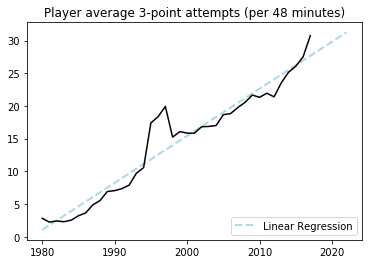

In [30]:
import matplotlib.pyplot as plt
plt.plot(pandas_pred.Year,pandas_pred.prediction, linewidth = 2, linestyle = '--',color = 'lightblue', label = 'Linear Regression')
plt.plot(df_pandas.Year, df_pandas.PA_per_game, color = 'black', label = None)
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 48 minutes)')